# Hornet Classifier Explations
We train a deep neurel net work classifier on cliped images of hornets and analyse these classifications using Layer-wise Relevance Propagarion (LRP).

In [1]:
import os
import sys
import cv2
import glob
import numpy as np
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

%matplotlib inline

from skimage import transform
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Root directory
root_dir = '/Users/Holmes/Research/Projects/vespalert'
sys.path.insert(0, os.path.join(root_dir, 'utils/lrp'))
sys.path.insert(0, os.path.join(root_dir, 'utils/lrp/notebooks'))

from LRP import lrp
from resnet import resnet50

# Data directory
data_dir = os.path.join(root_dir, 'datasets')
image_dir = os.path.join(data_dir, 'yoco30')

# New data
new_dir = os.path.join(data_dir, 'hornets')

# Weight path
weight_dir = os.path.join(root_dir, 'classifier/weights')


# Automatically reload imported programmes
%reload_ext autoreload
%autoreload 2

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Processing Units: ', device)

Processing Units:  cpu


In [25]:
check=lrp.LRP()
attrs = vars(check)


TypeError: __init__() missing 2 required positional arguments: 'model' and 'rule'

## Load and prepare the data
Data is stored in images with hornets identified in bounding boxes in the YOLO format. Fristly we import the labels and images from the files.

In [2]:
# Gather list of image filenames
batch_names = ['train', 'test', 'val']
image_files = []

for batch in batch_names:
    image_files += glob.glob(os.path.join(image_dir, 'images', batch, '*.*'))

# Load images
images = []
for file in image_files:
    images.append(cv2.imread(file))  # In BGR format

# Load corresponding labels
labels = []
for file in image_files:
    
    # Generate label_path
    if '/images/' in file:
        # Swap substrings /images/ for /labels/ and ammend ext to .txt
        head, tail = file.split('/images/')
        root = os.path.splitext(head + '/labels/' + tail)[0]
        label_path = root + '.txt'
        
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        labels.append(np.loadtxt(label_path, dtype=np.float32))


Next we extract and clip the boxed segments and store the corresponding class ID.

In [3]:
# Store extracted segments and corresponding class IDs
segments = []
classes = []
class_dict = {
    0: 'Vespa crabro',
    1: 'Vespa velutina',
}

# Iterate over images
for image, boxes in zip(images, labels):
    
    im_height, im_width, _ = image.shape
    
    # One box in image
    if boxes.size == 5:
        boxes = np.expand_dims(boxes, axis=0)
        
    if not boxes.size == 0:     
        for [class_number, x_center, y_center, width, height] in boxes:
            x0 = int(im_width * (x_center - width / 2))   # left-side x
            x1 = int(im_width * (x_center + width / 2))   # right-side x
            y0 = int(im_height * (y_center - height / 2))  # top-side y
            y1 = int(im_height * (y_center + height / 2))  # bottom-side x    
            segments.append(cv2.cvtColor(image[y0:y1, x0:x1, :], cv2.COLOR_BGR2RGB))
            classes.append(class_number)


Class:  0.0
Class name:  Vespa crabro


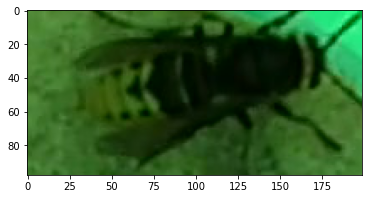

In [4]:
# Plot example

seg = np.random.randint(len(segments), size=1)[0]
img = segments[seg]
print('Class: ', classes[seg])
print('Class name: ', class_dict[classes[seg]])

plt.imshow(img)
plt.show()

Original image shape:  (1080, 1920, 3)
Raw box label data:  [0.    0.525 0.421 0.11  0.133]


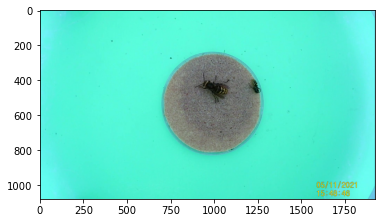

In [5]:
# A prototype original image
print('Original image shape: ', images[0].shape)
print('Raw box label data: ', labels[0])
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.show()

### Data split into train/test/val as 80:10:10 for processing.

In [6]:
# Shuffel data

# classified_data = list(zip(segments, classes))
# np.random.shuffle(classified_data)

# Split train/nontrain as 80:20
x_train, x_nontrain, y_train, y_nontrain = train_test_split(
    segments, classes, test_size=0.2, shuffle=True
)

# Split non-training data test/val as 10:10
x_test, x_val, y_test, y_val = train_test_split(
    x_nontrain, y_nontrain, test_size=0.2, shuffle=True
)

### Torch dataset

In [7]:
class HornetDataset(Dataset):
    """Hornet dataset for classification."""

    def __init__(self, images, targets, transform=None):
        """Args:
            images: List of numpy images in RGB format with varying dimensions.
            targets: List of target classes.
            transform (callable, optional): Transform to be applied on a sample.
        """
        self.images = images
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        sample = [self.images[idx], self.targets[idx]]
        
        if self.transform:
            sample = self.transform(sample)

        return sample

Image number:  0
Image shape:  (128, 194, 3)
Image class: Vespa crabro


Image number:  1
Image shape:  (228, 130, 3)
Image class: Vespa velutina


Image number:  2
Image shape:  (171, 217, 3)
Image class: Vespa velutina


Image number:  3
Image shape:  (192, 156, 3)
Image class: Vespa velutina




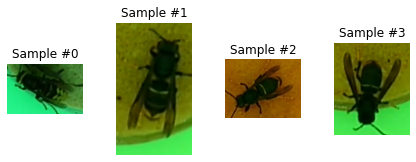

In [8]:
trainset0 = HornetDataset(x_train, y_train)

fig = plt.figure()

for i in range(len(trainset0)):
    sample = trainset0[i]
    
    print('Image number: ', i)
    print('Image shape: ', sample[0].shape) 
    print('Image class: {}'.format(class_dict[sample[1]]))
    print('\n')


    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0])

    if i == 3:
        plt.show()
        break

We need to preprocess the images to have the same shape and normalisation.

### Apply torch transforms
In particular we wish to define the callable tranforms
- Rescale
- RandomCrop (data augmentation)
- ToTensor

In [9]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        
        image = sample[0]
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        resized_image = transform.resize(image, (new_h, new_w))
        
        return [resized_image, sample[1]]


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size.
        If int, square crop is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample[0]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        cropped_image = image
        if h > new_h:
            top = np.random.randint(0, h - new_h)
            cropped_image = cropped_image[top: top + new_h, :, :]
        if w > new_w:
            left = np.random.randint(0, w - new_w)
            cropped_image = cropped_image[:, left: left + new_w, :]
        
        return [cropped_image, sample[1]]


class ToTensor(object):
    """Convert ndarray and target (float) in sample to torch.Tensors."""

    def __call__(self, sample):
        image, target = sample[0], sample[1]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return [torch.from_numpy(image).to(torch.float32).to(device),
                torch.tensor(target).to(torch.long).to(device),
                ]
    

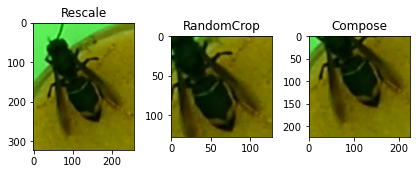

In [10]:
scale = Rescale(256)
crop = RandomCrop(128)
both = transforms.Compose([Rescale(256), RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = trainset0[65]
for i, aug in enumerate([scale, crop, both]):
    aug_sample = aug(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(aug).__name__)
    plt.imshow(aug_sample[0])

plt.show()

In [11]:
# Apply these to the dataset

trainset = HornetDataset(
    x_train, y_train, transform=transforms.Compose(
        [Rescale((256, 256)), RandomCrop((224, 224)), ToTensor()]
    ))

for i in range(len(trainset)):
    sample = trainset[i]
    print('Image number: ', i)
    print('Image shape: ', sample[0].shape) 
    print('Image class: {}'.format(class_dict[int(sample[1])]))
    print('\n')
    
    if i == 3:
        break

Image number:  0
Image shape:  torch.Size([3, 224, 224])
Image class: Vespa crabro


Image number:  1
Image shape:  torch.Size([3, 224, 224])
Image class: Vespa velutina


Image number:  2
Image shape:  torch.Size([3, 224, 224])
Image class: Vespa velutina


Image number:  3
Image shape:  torch.Size([3, 224, 224])
Image class: Vespa velutina




### Construct dataloader

0 torch.Size([4, 3, 224, 224])
1 torch.Size([4, 3, 224, 224])
2 torch.Size([4, 3, 224, 224])
3 torch.Size([4, 3, 224, 224])


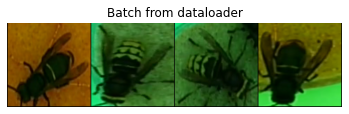

In [12]:
batch_size = 4
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

# Helper function to show a batch
def show_batch(sample_batched):
    """Show image for a batch of samples."""
    images_batch = sample_batched[0]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(trainloader):
    print(i_batch, sample_batched[0].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [13]:
testset = HornetDataset(
    x_test, y_test, transform=transforms.Compose([Rescale((256, 256)), ToTensor()])
)
testloader = DataLoader(testset, batch_size=1, shuffle=True, num_workers=0)

## Construct and train Network

In [14]:
class SimpleNet(nn.Module):
    
    def __init__(self, num_classes=2):
        super(SimpleNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5),
            nn.MaxPool2d(4),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=5),
            nn.MaxPool2d(4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.MaxPool2d(4),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, num_classes),
           # nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128)
        x = self.classifier(x)
        return x
    
    
class ResNet2(nn.Module):

    def __init__(self, num_classes=2):
        super(ResNet2, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(1000, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, num_classes),
           # nn.ReLU()
        )
        
        self.resnet = resnet50(pretrained=True)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)
        return x
    

### Instantiate network and optimisation approach

In [15]:
# Load ResNet from 'LRP_decomposition'
sys.path.insert(0, os.path.join(root_dir, 'LRP_decomposition/notebooks'))

model = SimpleNet(num_classes=2).to(device)
model = model.eval()

criterion = torch.nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Pre-checks

torch.Size([1, 3, 224, 224])
torch.Size([1, 32, 2, 2])
tensor([[-0.0718, -0.0394]])
tensor([0.4919, 0.5081])


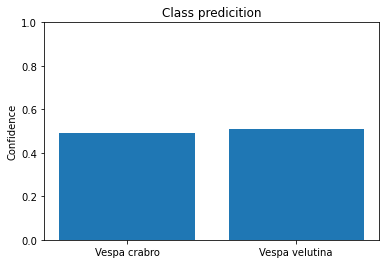

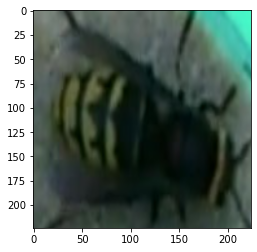

In [16]:
trainiter = iter(trainloader)
image, label = trainiter.next()

n = 1
output2 = model(image[n].unsqueeze(0))

print(output2.detach())
print(torch.softmax(output2, dim=-1).squeeze().detach())

plt.bar([0,1], torch.softmax(output2, dim=-1).squeeze().detach())
plt.xticks([0,1], [class_dict[0], class_dict[1]])
plt.ylim([0,1])
plt.ylabel('Confidence')
plt.title('Class predicition')
plt.show()
plt.imshow(image[n].numpy().transpose((1, 2, 0)))

### Iterate training proceedure

In [17]:
num_epochs = 2
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        
        inputs, labels = data

        # Zero the parameter gradients
        optimiser.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        # Backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Update parameters
        optimiser.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

1it [00:00,  9.96it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


3it [00:00, 10.06it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


6it [00:00,  8.95it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


8it [00:00,  9.16it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


10it [00:01, 10.22it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


14it [00:01, 11.99it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


16it [00:01, 12.33it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


20it [00:01, 12.49it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


22it [00:01, 12.65it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


24it [00:02, 12.03it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


26it [00:02, 11.26it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


28it [00:02, 10.52it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


30it [00:02, 10.15it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


34it [00:03, 10.80it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


36it [00:03, 11.08it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


38it [00:03, 11.29it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


40it [00:03, 10.81it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


42it [00:03,  9.99it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


45it [00:04,  9.25it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


47it [00:04,  8.52it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


49it [00:04,  8.54it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


51it [00:05,  8.35it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


53it [00:05,  8.15it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


55it [00:05,  8.22it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


57it [00:05,  8.73it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


59it [00:05,  8.84it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


61it [00:06,  8.91it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


63it [00:06,  8.75it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


65it [00:06,  8.06it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


68it [00:06, 10.22it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


70it [00:07, 11.20it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


74it [00:07, 12.95it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


76it [00:07, 12.24it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


80it [00:07, 11.64it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


82it [00:08, 11.50it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


86it [00:08, 11.51it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


88it [00:08, 11.74it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


92it [00:08, 13.25it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


96it [00:09, 14.44it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


100it [00:09, 15.05it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


104it [00:09, 15.87it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


108it [00:09, 15.88it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


112it [00:10, 16.20it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


116it [00:10, 16.59it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


120it [00:10, 16.31it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


122it [00:10, 15.59it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


126it [00:10, 15.41it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


130it [00:11, 14.65it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


132it [00:11, 14.56it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


136it [00:11, 14.26it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


138it [00:11, 13.99it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


142it [00:12, 13.83it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


144it [00:12, 13.62it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


148it [00:12, 13.29it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


150it [00:12, 13.17it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


154it [00:13, 13.03it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


156it [00:13, 12.88it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


160it [00:13, 12.62it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


162it [00:13, 12.21it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


164it [00:13, 11.38it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


166it [00:14, 10.91it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


168it [00:14, 10.50it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


170it [00:14, 10.48it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


174it [00:14, 10.66it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


176it [00:15, 10.34it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


178it [00:15, 10.24it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


180it [00:15, 10.31it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


182it [00:15, 10.18it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


184it [00:15, 10.05it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


187it [00:16,  9.82it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


189it [00:16,  9.68it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


190it [00:16,  9.53it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


193it [00:16,  9.67it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


197it [00:17, 12.10it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


199it [00:17, 12.93it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


201it [00:17, 13.40it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


207it [00:17, 13.44it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


209it [00:17, 14.09it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


213it [00:18, 13.60it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


217it [00:18, 12.79it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


219it [00:18, 12.81it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


223it [00:19, 14.01it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


227it [00:19, 14.64it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


231it [00:19, 15.23it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


233it [00:19, 15.51it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


237it [00:19, 14.43it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


239it [00:20, 14.45it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


245it [00:20, 15.96it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


249it [00:20, 16.17it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


253it [00:20, 16.38it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


257it [00:21, 15.79it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


261it [00:21, 16.08it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


265it [00:21, 16.40it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


269it [00:21, 16.10it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


271it [00:22, 15.77it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


275it [00:22, 14.94it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


279it [00:22, 15.60it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


283it [00:22, 15.67it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


287it [00:23, 16.11it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


291it [00:23, 14.17it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


293it [00:23, 13.32it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


297it [00:23, 12.06it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


299it [00:24, 12.55it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


303it [00:24, 13.47it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


307it [00:24, 14.50it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


309it [00:24, 14.69it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


315it [00:25, 15.45it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


319it [00:25, 15.74it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


323it [00:25, 15.70it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


327it [00:25, 16.13it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


331it [00:26, 16.26it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


332it [00:26, 12.68it/s]


torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


2it [00:00, 16.30it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


4it [00:00, 16.29it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


6it [00:00, 15.56it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


8it [00:00, 15.76it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


10it [00:00, 16.06it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


12it [00:00, 16.05it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


14it [00:00, 15.96it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


16it [00:00, 16.26it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


18it [00:01, 16.44it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


20it [00:01, 16.14it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


22it [00:01, 16.42it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


24it [00:01, 16.41it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


26it [00:01, 16.30it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


28it [00:01, 16.50it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


30it [00:01, 16.32it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


32it [00:01, 16.41it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


34it [00:02, 16.36it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


36it [00:02, 16.46it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


38it [00:02, 16.23it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


40it [00:02, 16.18it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


42it [00:02, 16.26it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


44it [00:02, 16.06it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


46it [00:02, 16.26it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


48it [00:02, 16.27it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


50it [00:03, 16.22it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


52it [00:03, 16.12it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


54it [00:03, 16.18it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


56it [00:03, 16.38it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


58it [00:03, 16.41it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


60it [00:03, 16.27it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


62it [00:03, 16.21it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


64it [00:03, 16.32it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


66it [00:04, 15.88it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


70it [00:04, 15.76it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


72it [00:04, 15.84it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


76it [00:04, 13.11it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


80it [00:05, 14.39it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


82it [00:05, 11.59it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


84it [00:05, 12.59it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


86it [00:05, 13.43it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


88it [00:05, 14.02it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


90it [00:05, 14.67it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


92it [00:05, 14.99it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


94it [00:06, 15.29it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


96it [00:06, 15.29it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


98it [00:06, 15.29it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


100it [00:06, 15.50it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


104it [00:06, 15.64it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


106it [00:06, 15.73it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


108it [00:06, 15.78it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


110it [00:07, 15.73it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


112it [00:07, 15.94it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


114it [00:07, 15.65it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


116it [00:07, 16.05it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


118it [00:07, 16.14it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


120it [00:07, 16.16it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


122it [00:07, 16.05it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


124it [00:07, 16.10it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


126it [00:08, 15.93it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


128it [00:08, 16.03it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


130it [00:08, 15.97it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


132it [00:08, 15.88it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


134it [00:08, 15.82it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


136it [00:08, 15.94it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


138it [00:08, 15.76it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


140it [00:08, 15.90it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


142it [00:09, 15.82it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


144it [00:09, 15.98it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


146it [00:09, 16.01it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


148it [00:09, 16.02it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


150it [00:09, 15.89it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


152it [00:09, 16.05it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


154it [00:09, 15.87it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


156it [00:09, 16.10it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


158it [00:10, 15.90it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


160it [00:10, 16.09it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


162it [00:10, 14.96it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


164it [00:10, 14.70it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


166it [00:10, 14.38it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


168it [00:10, 14.47it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


174it [00:11, 15.30it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


178it [00:11, 15.61it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


180it [00:11, 15.30it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


186it [00:11, 15.79it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


190it [00:12, 15.98it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


194it [00:12, 15.93it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


196it [00:12, 15.92it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


202it [00:12, 16.00it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


206it [00:13, 15.97it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


210it [00:13, 16.24it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


214it [00:13, 16.02it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


218it [00:13, 16.26it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


222it [00:14, 16.04it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


226it [00:14, 15.99it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


230it [00:14, 16.24it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


234it [00:14, 16.07it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


236it [00:15, 15.31it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


242it [00:15, 16.18it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


246it [00:15, 16.13it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


250it [00:15, 16.03it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


254it [00:16, 16.03it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


258it [00:16, 16.13it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


262it [00:16, 16.09it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


264it [00:16, 15.99it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


268it [00:17, 13.37it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


272it [00:17, 14.52it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


276it [00:17, 14.89it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


278it [00:17, 14.80it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


282it [00:18, 15.04it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


286it [00:18, 15.06it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


288it [00:18, 14.80it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


294it [00:18, 15.60it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


296it [00:19, 15.51it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


302it [00:19, 16.04it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


304it [00:19, 15.67it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


310it [00:19, 16.02it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


314it [00:20, 15.92it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


316it [00:20, 15.40it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])


320it [00:20, 15.61it/s]

torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


324it [00:20, 15.94it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


328it [00:21, 15.99it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])


332it [00:21, 15.58it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
torch.Size([4, 3, 224, 224])
torch.Size([4, 32, 2, 2])
Finished Training


In [18]:
weight_path = os.path.join(weight_dir, 'simple_one.pth')
torch.save(model.state_dict(), weight_path)

### Post checks

torch.Size([1, 3, 224, 224])
torch.Size([1, 32, 2, 2])
tensor([[-0.1114, -0.0029]])
tensor([0.4729, 0.5271])


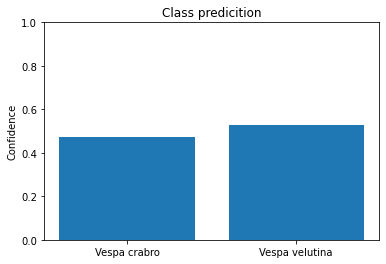

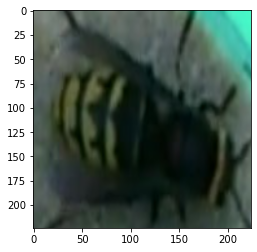

In [28]:
n = 1
input3 = image[n].unsqueeze(0)
output3 = model(input3)

print(output3.detach())
print(torch.softmax(output3, dim=-1).squeeze().detach())

plt.bar([0,1], torch.softmax(output3, dim=-1).squeeze().detach())
plt.xticks([0,1], [class_dict[0], class_dict[1]])
plt.ylim([0,1])
plt.ylabel('Confidence')
plt.title('Class predicition')
plt.show()
plt.imshow(image[n].numpy().transpose((1, 2, 0)))

## LRP analysis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])
torch.Size([1, 32, 2, 2])


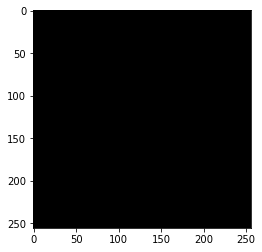

In [29]:
model_lrp = lrp.LRP(model, 'z_plus')
random_in = torch.rand(1,3,256,256)
relevance = model_lrp.relprop(random_in)
plt.imshow(relevance.squeeze().permute(1,2,0))


torch.Size([1, 3, 224, 224])
torch.Size([1, 32, 2, 2])


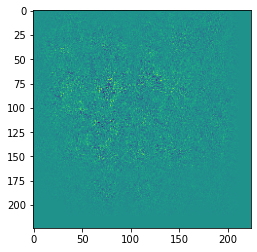

In [30]:
relevance = model_lrp.relprop(input3)
plt.imshow(relevance.squeeze().permute(1,2,0)[:,:,0])

torch.Size([1, 3, 224, 224])
torch.Size([1, 32, 2, 2])


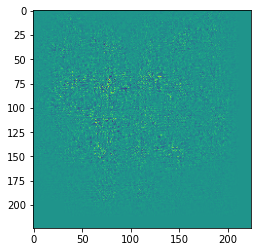

In [31]:
relevance = model_lrp.relprop(input3)
plt.imshow(relevance.squeeze().permute(1,2,0)[:,:,1])

torch.Size([1, 3, 224, 224])
torch.Size([1, 32, 2, 2])


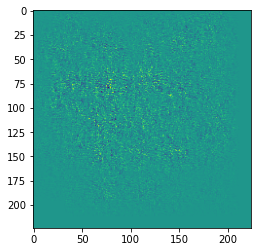

In [32]:
relevance = model_lrp.relprop(input3)
plt.imshow(relevance.squeeze().permute(1,2,0)[:,:,2])